Using TensorFlow backend.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 50)           20200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 300, 1)            51        
_________________________________________________________________
average_pooling1d_1 (Average (None, 1, 1)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
Total params: 520,251
Trainable params: 520,251
Non-trainable params: 0
_________________________________________________________________







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train o

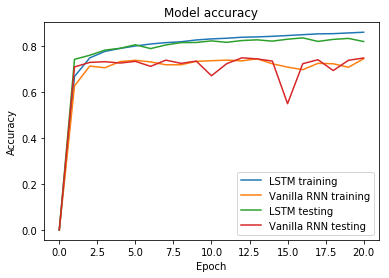

In [2]:
# NLP sentiment analysis
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, SimpleRNN, Embedding
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import models, layers

import os
base_dir = 'IMDB_dataset'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
# train_pos = os.path.join(train_dir,'pos')
# train_neg = os.path.join(train_dir,'neg')
# test_pos = os.path.join(test_dir,'pos')
# test_neg = os.path.join(test_dir,'neg')
train_texts = []
train_labels = []
test_texts = []
test_labels = []
for label_type in ['pos','neg']:
  dir_name = os.path.join(train_dir,label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name,fname))
      train_texts.append(f.read())
      f.close()
      if label_type == 'neg':
        train_labels.append(0.0)
      else:
        train_labels.append(1.0)
for label_type in ['pos','neg']:
  dir_name = os.path.join(test_dir,label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name,fname))
      test_texts.append(f.read())
      f.close()
      if label_type == 'neg':
        test_labels.append(0.0)
      else:
        test_labels.append(1.0)
        
# print(f'Length of texts is {len(train_texts)}')
# print(f'Length of labels id {len(train_labels)}')
# print(f'Length of test_texts is {len(test_texts)}')
# print(f'Length of test_labels is {len(test_labels )}')
# for each is 25,000


max_length = 300
units = 50
#try 20000
max_words = 10000
#import embedding vector with dimension 50
embedding_dimension = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
word_index = tokenizer.word_index
# print(f'Found {len(word_index)} unique tokens.')
# #use all kinds of vocabulary
# max_words = len(word_index)
train_data = pad_sequences(sequences,maxlen=max_length)
train_labels = np.array(train_labels)
# print(f'Shape of Data tensor is {train_data.shape}')
# print(f'Shape of Labels tensor is {train_labels.shape}')
X_train, X_val, y_train, y_val = train_test_split(train_data,train_labels,test_size=0.2,random_state=50)
glove_dir = os.path.join('drive','glove.6B.50d.txt')
embedding_index = {}
f = open(glove_dir)
for line in f:
  values = line.split()
  word = values[0]
  correlation_vector = np.array(values[1:],dtype='float32')
  embedding_index[word] = correlation_vector
f.close()
# print(f'Found {len(embedding_index)} word vectors')
#400,000 word vectors
# print(embedding_index['great'])
embedding_matrix = np.zeros((max_words,embedding_dimension))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      
      
embedding_matrix2 = embedding_matrix.copy()

# print("1",np.sum(embedding_matrix))
# print("2",np.sum(embedding_matrix2))
      
training_times = 20
      
model = models.Sequential()
model.add(layers.Embedding(max_words,embedding_dimension,input_length=max_length))
#state dimension will be 20,50,100,200,500
model.add(layers.LSTM(units=units,return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(1,activation='sigmoid')))
model.add(layers.AveragePooling1D(max_length))
model.add(layers.Flatten())
# model.add(layers.SimpleRNN(max_length))
# model.add(layers.Dense(1,activation='sigmoid'))
model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='Adam',loss='mean_squared_error',metrics=['acc'])
history = model.fit(X_train,y_train,epochs=training_times,batch_size=100,validation_data=(X_val,y_val))

# print("1_again",np.sum(embedding_matrix))
# print("2_again",np.sum(embedding_matrix2))

model2 = models.Sequential()
model2.add(layers.Embedding(max_words,embedding_dimension,input_length=max_length))
#state dimension will be 20,50,100,200,500
# model.add(layers.LSTM(max_length))
model2.add(layers.SimpleRNN(units=units,return_sequences=True))
model2.add(layers.TimeDistributed(layers.Dense(1,activation='sigmoid')))
model2.add(layers.AveragePooling1D(max_length))
model2.add(layers.Flatten())
# model2.add(layers.Dense(1,activation='sigmoid'))
model2.summary()
model2.layers[0].set_weights([embedding_matrix2])
model2.layers[0].trainable = False
model2.compile(optimizer='Adam',loss='mean_squared_error',metrics=['acc'])
history2 = model2.fit(X_train,y_train,epochs=training_times,batch_size=100,validation_data=(X_val,y_val))

# Plot training & validation accuracy values
# plt.plot([0.0]+history.history['acc'])
plt.plot([0.0]+history.history['acc'],'-',label="LSTM training")
plt.plot([0.0]+history2.history['acc'],'-',label="Vanilla RNN training")
plt.plot([0.0]+history.history['val_acc'],'-',label="LSTM testing")
plt.plot([0.0]+history2.history['val_acc'],'-',label="Vanilla RNN testing")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='lower right')
plt.legend(loc='lower right')
plt.show()

# model.save_weights("model_weights.h5")

In [1]:
!rm -rf *
!git clone https://github.com/RichardChangCA/IMDB_dataset.git
!ls IMDB_dataset/


!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

!ls drive

Cloning into 'IMDB_dataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 98504 (delta 1), reused 8 (delta 1), pack-reused 98496
Receiving objects: 100% (98504/98504), 95.63 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (200029/200029), done.
aclImdb		   glove.6B.50d.txt  imdb.vocab  test
glove.6B.100d.txt  imdbEr.txt	     README	 train
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL

In [0]:
!rm -rf *
!git clone https://github.com/RichardChangCA/IMDB_dataset.git
!ls IMDB_dataset/

Cloning into 'IMDB_dataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 98504 (delta 1), reused 8 (delta 1), pack-reused 98496
Receiving objects: 100% (98504/98504), 95.63 MiB | 17.59 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (200029/200029), done.
aclImdb		   glove.6B.50d.txt  imdb.vocab  test
glove.6B.100d.txt  imdbEr.txt	     README	 train


In [0]:
!cat IMDB_dataset/glove.6B.50d.txt

version https://git-lfs.github.com/spec/v1
oid sha256:d8f717f8dd4b545cb7f418ef9f3d0c3e6e68a6f48b97d32f8b7aae40cb31f96f
size 171350079


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls drive

'Colab Notebooks'
'Copy of DL_A1_Collection-checkpoint.ipynb（副本）'
'DL_module01 (01570add).pdf'
 DL_module01.pdf
 DL_module02.pdf
 glove.6B.50d.txt
 Topic1_IngredientsML.pdf
'Topic2_ClassificationEval (22347a07).pdf'
 Topic2_ClassificationEval.pdf
